# Classification Step-by-Step

### Setup

In [131]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## MNIST dataset

MNIST is a dataset of 70,000 small images of handwritten digits. Each image is labelled with the corresponding digit it represents.<br>
Scikit-learn provides helper functions to download popular datasets. Datasets loaded by Scikit-learn have a similar dictionary structure.<br>
`DESCR`: describes the dataset<br>
`data`: an array with one row per instance and one column per feature<br>
`target`: an array with the labels

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are `70,000` images and each image has `784` features. This is so because the images are `28x28` pixels, and each feature is a representation of one pixel's intensity from `0 (white)` to `255 (black)`.

### Viewing the contents in the dataset

To do so, get an instance's feature vector, reshape it to a 28x28 feature vector and the plot using matplotlib.

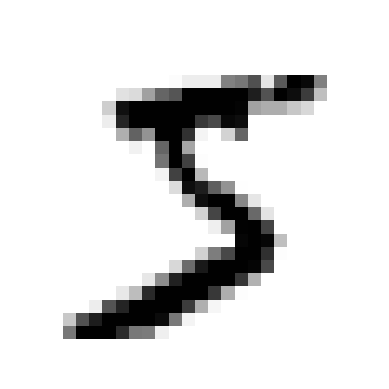

In [4]:
some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
# Checking the corresponding label
y[0]

'5'

Most ML algorithm expects numbers, so we type cast the string labels to integers.

In [6]:
y = y.astype(np.uint8)

## Creating a test set and training set

The MNIST dataset is already split between training and testing sets. The first `60,000` items are training set, and the last `10,000` items are the testing set.<br>
The training set is already shuffled, which is good because all cross-validation folds will be similar (you don't want one cross-validation fold to be missing some digits). Shuffling is also good in cases where the training model is sensitive to the order of training instances and may be skewed if it gets many similar instances ina row.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Training a classifier for a single number i.e. a detector for the number `7`

In [8]:
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

A starting point can be the `Stochastic Gradient Descent` like the Scikit-learn SGDClassifier. This classifier has the advantage of being abl to handle large datasets efficiently.
SGD deals with training instances independently which also makes it good for online training.

In [9]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

## Performance Measures

### Measuring accuracy using cross-validation
In some cases the cross-validation function offered by Scikit-learn may be insufficient for you needs, it is possible to implement a custom cross-validation function. Check the book for more details.<br>
K-fold cross-validation involves splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining K folds.

In [11]:
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.98105, 0.9735 , 0.95335])

The cross-validation scores above show the model to have an accuracy of above 95% on each fold. Using accuracy is not a good performance measure for classifiers especially when dealing with skewed datasets (some classes appear more than others).

## Confusion Matrix
Offers a better way of evaluating a classifier's performance. It aims to show how many times instances of class A were classified as instances of class B. To compute a confusion matrix you need a set of predictions that can be compared to actual values, to get the set of prections we can use the `cross_val_predict`. `cross_val_predict` performs K-fold validation but instead of returning validation scores it returns the predictions made on each fold.

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

To get the confusion matrix use `confusion_matrix` function, passing it the target class and the predicted classes.

In [13]:
confusion_matrix(y_train_7, y_train_pred)

array([[52581,  1154],
       [  688,  5577]])

Each row in a confusion matrix represents an `actual class` and each column represnts a `predicted class`.<br>
The first row in the matrix above considers `non-7` images (negative class). 52581 were correctly identified as not 7 (`true negatives`) while 1154 were incorrectly identified as 7 (`false positives`).<br>
The second row considers images of 7 (positive class). 688 were incorrectly identified as not 7 (`false negatives`) while 5577 images were correctly identified as 7s (`true positives`)<br>

A perfect classifier would have only true negatives and true positives hence having non-zero values only on its main diagonal (top left to bottom right).

In [14]:
## Example of confusion matrix for a perfect classifier
y_train_perfect_pred = y_train_7 # assume we have a trained a perfect classifier
confusion_matrix(y_train_7, y_train_perfect_pred)

array([[53735,     0],
       [    0,  6265]])

The confusion matrix can be used to derive more concise metrics, specifically `precision` and `recall` that are used alongside each other.<br>
`Precision` is the accuracy of positive predictions. It is given by True postives/(True positives + False positives)<br>
`Recall` is the ratio of positive instances correctly detected by the classifier. It is given by True positives/(True positives + False Negatives)

In [15]:
precision_score(y_train_7, y_train_pred)

0.8285544495617293

In [16]:
recall_score(y_train_7, y_train_pred)

0.8901835594573024

From the scores above, when the classifier claims an image is 7 it is accurate only 82.85% of the time. Moreover, it only detects 89.01% of all 7s. These metrics don't look so good as it were when accuracy was used to measure performance.

It might be convenient sometimes to combine the precision and recall scores to get a new score called F1 score. It is especially useful when comparing two classifiers. F1 score is the harmonic mean of precision and recall.<br>
The classifier only gets a high F1 score if both the precision and recall scores are high.

In [17]:
f1_score(y_train_7, y_train_pred)

0.858264081255771

Increasing precision reduces recall, and vice versa. This is called the `precision/recall trade-off`

The precision/recall trade-off is determined by which the threshold the classifier uses to categorize instances as positive or negative. To decide which threshold to use:
- Use cross_val_predict to get the scores for each instance by specifying it to return decision scores instead of predicted values
- With those scores, use the `precision_recall_curve` function to compute precision and recalls for all possible thresholds.
- Plot precision and recall as functions of the threshold value. Or plot precision against the recall value.
  

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3, method="decision_function")

In [66]:
precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

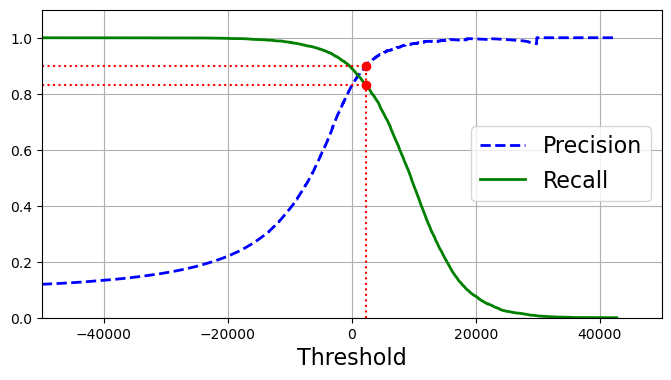

In [72]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1.1])


# Suppose you are aiming for 90% precision
# Search for the lowest threshold that gives you 90% precision.
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

Another way to select a precision/recall tradeoff is by plotting precision directly against recall.

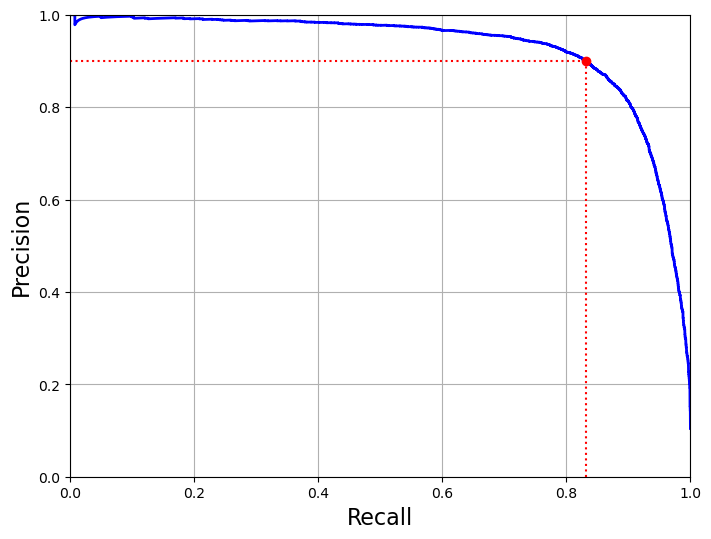

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

The plot above shows precision starts falling off sharply at around 80% - 85% recall. It would then be optimal to select a precision/recall tradeoff just around that range mark.

Examining the recall of a classifier using 90% accuracy.

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_7, y_train_pred_90)

0.9000864304235091

In [36]:
recall_score(y_train_7, y_train_pred_90)

0.8311252992817239

### The ROC Curve
The `receiver operating characteristic` curve is another metric used for binary classifiers. It is similar to the precision/recall curve except that is plots the `true positive rate (recall)` vs the `false positive rate`. The false positive rate is the ratio of negative instances that are incorrectly classified as positive.

In [58]:
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

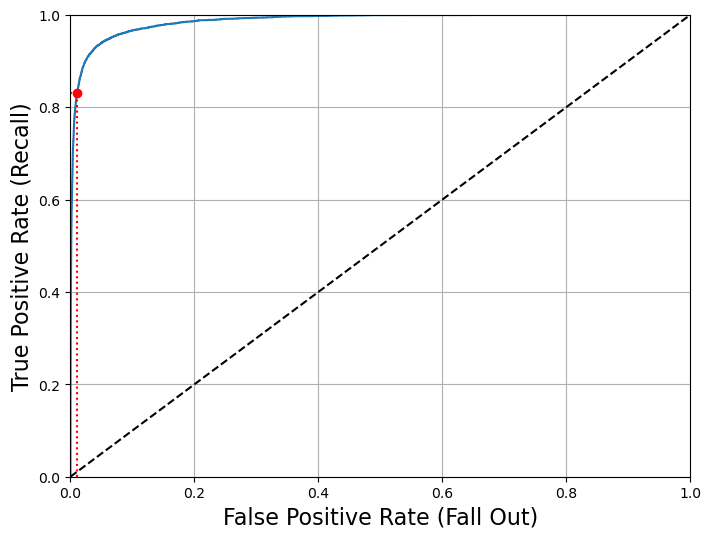

In [84]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate (Fall Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

Once again there is a tradeoff: the higher the recall (TPR) the more the false positives (FPR) the classifier produces.<br>
The dotted diagonal line shows the ROC curve of a purely random classifier. A good classifier stays a far away from this dotted line as possible (towards the top left corner).

Classifiers can also be compared by measuring the `Area Under Curve (AUC)`. A perfect classifier will have an ROC AUC equal 1, whereas a purely random classifier will have an ROC AUC equal 0.5.

In [53]:
roc_auc_score(y_train_7, y_scores)

0.986670497551944

#### When to use the ROC or P/R curves
The ROC and P/R curve are pretty similar. A good rule of thumb on when to use which curve: use the P/R curve when the positive class is rare or you are more concerned about false positives than false negatives. Otherwise use the ROC curve and ROC AUC score.

#### Training a Random Forest classifier and comparing its ROC and AUC to the SGDClassifier

In [81]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, threshold = roc_curve(y_train_7, y_scores_forest)

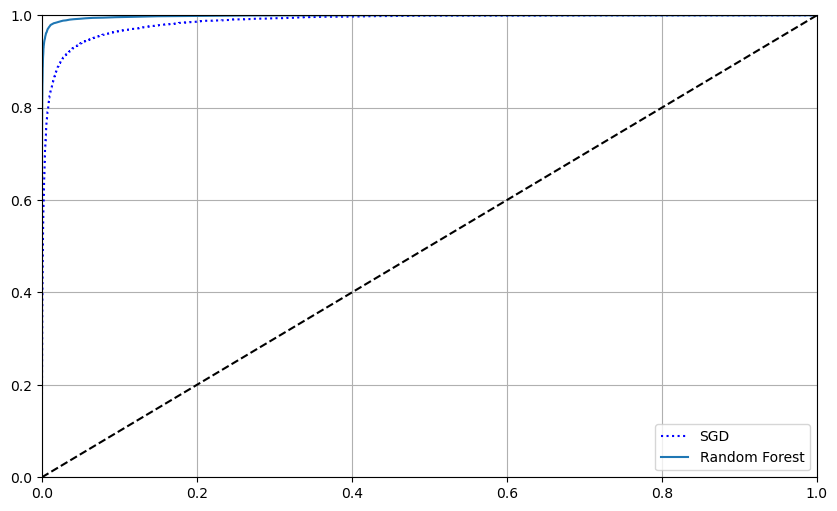

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

Compare the ROC AUC score of the RandomFOrestClaasifier model

In [83]:
roc_auc_score(y_train_7, y_scores_forest)

0.9982747530426836

In [90]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3)

In [91]:
precision_score(y_train_7, y_train_pred_forest)

0.9867364746945899

In [92]:
recall_score(y_train_7, y_train_pred_forest)

0.9024740622505986

The RandomForestClassifier model outperforms the Binary Classifier on all the metrics above: precision, recall, roc_auc.

## Multiclass Classification

Multiclass/Multinomial classifiers can distinguish between more than two classifiers.<br>
There are some strategies for using binary classifiers to do multiclass classification. Such as:
- one-versus-the-rest (OVR) strategy
- one-versus-one (OVO) strategy
For models that scale poorly with the training set size, OVO is preferred since it is easier to train many smaller models than to train few large models.<br>
Scikit-learn can determine when you're using binary classification for multicalss classification, and automatically run OVR or OVO.

#### Support Vector Machine classifier

In [97]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

Under the hood Scikit-learn used OVO strategy, training 45 binary classifiers, got their decision scores for the image and selected the class that won the most duels.

If you call the `decision_function()` it will return 10 scores per instance, instead of just 1, that gives one score per class. The highest score corresponds to the class the model predicts as positive.

In [98]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [99]:
np.argmax(some_digit_scores)

5

When a classifier is trained, it stores a list of target classes in a `classes_` attribute, ordered by value. In this case, the index of each class in the classes_ array convenently matches the class itself.

In [102]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [101]:
svm_clf.classes_[5]

5

To force Scikit-learn to use OvR or OvO strategy, you can use the OneVsOneClassifier or OneVsRestClassifier classes by creating an instance and passing a classifier to it's constructor.<br>
For example the code below shows how to create a OvR classifier based on SVC.

In [104]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not h

array([5], dtype=uint8)

In [105]:
len(ovr_clf.estimators_)

10

Training a SGDClassifier or Random Forest Classifier is just as easy. In these cases, Scikit-learn doesn't have to use OvR or OvO strategies since the algorithms are capable of handling multiple classes.

In [106]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

The decision_function() now returns one value per class.

In [107]:
sgd_clf.decision_function([some_digit])

/home/cmmasaba/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Using cross-validation to evaluate the model.

In [108]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Scaling the imputs improves the classifier slightly

In [112]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis
Error analysis is used to improve shortlisted models.<br>
One way is to look at the confusion matrix.

In [118]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

It is often better looking at the visual representation of the confusion matrix when it has many numbers

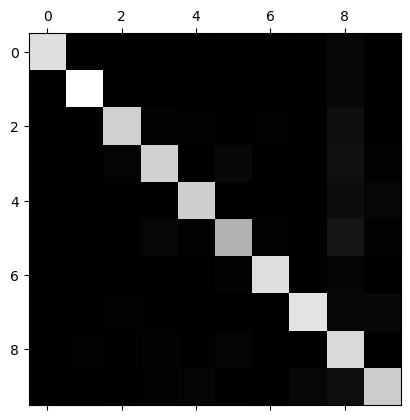

In [119]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The confusion matrix looks quite good, since most images are on the main diagonal, showing they were classified correctly. The 5s look slightly darker than other digits. This could be because there are fewer 5s in the dataset or the classifer doesn't perform well on 5 as on other digits.

In [121]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

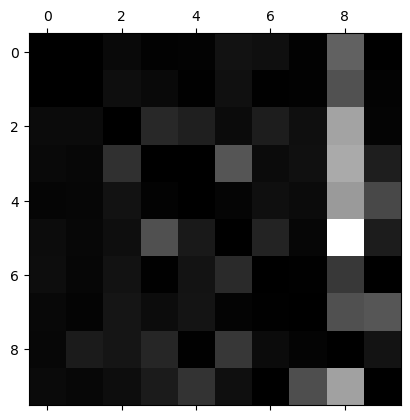

In [124]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual classes while columns represent predicted classes. From the plot above, one can tell the kind of errors the classifier makes.<br>
The column for number 8 is bright, which shows many images get misclassified as number 8. However the row for number 8 isn't bad, which shows actual 8s are indeed classified as 8.<br>
You can also see 3 and 5 get misclassified in both directions.

After analyzing the confusion matrix above, insights on how to improve the model include:
- reducing false 8s

Analyzing individual erros is also a good way of seeing what the classifier is doing and why it could be failing. However it is more time consuming. An example would be an investigation of 3s and 5s.

In [130]:
cl_a, cl_b = 3, 5
Xaa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
Xab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
Xba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
Xbb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(Xaa[:25], images_per_row=25)
plt.subplot(222); plot_digits(Xab[:25], images_per_row=25)
plt.subplot(223); plot_digits(Xba[:25], images_per_row=25)
plt.subplot(224); plot_digits(Xbb[:25], images_per_row=25)
plt.show()

The two 5x5 blocks on the left show images classified as 3s and the two 5x5 blocks on the right show images classified as 5s.<br>
Some of the errors seem obvious and shouldn't be occuring. However since the classifier used is SGDClassifier, which is a linear model, all it does is it assigns a wieght per class for each pixel and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. Since 3 and 5 differ by only a few pixels, this model is liable to confuse them.

## Multilabel Classification
In some cases you may want the classifier to output multiple classes per instance. For example consider a classifier that classifies whether an image is odd and is large i.e. 7, 8 or 9.

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 0)
y_train_multilabel = np.c_[y_train_large, y_train__odd]

knn_clf = KNeighborsClassifer()
knn_clf.fit(X_train, y_train_multilabel)
knn_clf.predict([some_digit])

There are many ways of evaluating a multilabel classifier. One method is to compute the f1 score of individual labels and then computing the average. The example below assumes each class has equal importance. However in some cases that may not be true, one class may have more importance or may occur more often than the other. In such cases, the `average` is set to `weighted`.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multilabel, cv=3)
f1_score(y_train_multilabel, y_train_knn_pred, average='macro')